# Classify using latent features

In [1]:
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

!apt-get install graphviz
!pip install pydot graphviz

import pydot
pydot.Dot.create(pydot.Dot())

from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn import tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,154 kB of

In [2]:
!pwd


/content


In [3]:
from google.colab import files

if os.path.exists('/content/tybalt/data/clinical_data.tsv'):
  data_exists=True
else:
  data_exists=False

if not data_exists:
  
  if not os.path.exists('/content/tybalt/data'):
    !mkdir -p tybalt/data

  os.chdir('/content/tybalt')
  uploaded = files.upload()

  for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    
  !mv *.tsv data/
  !ls data
else:
  os.chdir('/content/tybalt')
  
  

Saving clinical_data.tsv to clinical_data.tsv
User uploaded file "clinical_data.tsv" with length 1954970 bytes
clinical_data.tsv


In [4]:
  uploaded = files.upload()
  for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    
  !mv *.tsv data/

Saving encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv to encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv
User uploaded file "encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv" with length 3198060 bytes


In [5]:
!ls data

clinical_data.tsv  encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv


In [0]:
# Input files needed for this notebook
clinical_file = os.path.join('data', 'clinical_data.tsv')
activation_file = os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm_36dim.tsv')

Load the activations of latent features for each patient tumor sample.

In [7]:
# load the activations of all tumors.
activations = pd.read_table(activation_file)

# create sample id from the tumor id
activations['sample_id']=activations.tcga_id.apply(lambda x:x[:12])
print(activations.shape)
activations.head(3)

(10459, 38)


,tcga_id,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,sample_id
0,TCGA-02-0047-01,0.0,0.000000,0.0,9.652770,0.0,4.159220,1.032724,1.333893,0.000000,...,4.095537,0.000000,0.0,0.248807,0.272327,3.184963,0.0,2.675518,0.000000,TCGA-02-0047
1,TCGA-02-0055-01,0.0,1.512052,0.0,4.649414,0.0,3.986379,1.551740,6.000260,0.000000,...,3.933533,0.000000,0.0,0.000000,0.299276,0.604121,0.0,0.000000,0.000000,TCGA-02-0055
2,TCGA-02-2483-01,0.0,3.843754,0.0,7.305416,0.0,6.712879,0.000000,3.738884,0.382847,...,6.744939,0.401072,0.0,1.256845,0.000000,3.929856,0.0,6.264098,0.502557,TCGA-02-2483


In [8]:
cases = pd.read_table(clinical_file)
diagnosis = cases[['sample_id', 'acronym', 'gender']]
diagnosis.head()

,sample_id,acronym,gender
0,TCGA-CD-8534,STAD,male
1,TCGA-ER-A19A,SKCM,male
2,TCGA-C5-A1M8,CESC,female
3,TCGA-D1-A0ZN,UCEC,female
4,TCGA-EM-A4FF,THCA,female


In [9]:
activations = pd.merge(activations, diagnosis, how='left')
activations.shape

(12175, 40)

In [10]:
activations.head()

,tcga_id,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,sample_id,acronym,gender
0,TCGA-02-0047-01,0.0,0.000000,0.000000,9.652770,0.0,4.159220,1.032724,1.333893,0.000000,...,0.000000,0.248807,0.272327,3.184963,0.000000,2.675518,0.000000,TCGA-02-0047,GBM,male
1,TCGA-02-0055-01,0.0,1.512052,0.000000,4.649414,0.0,3.986379,1.551740,6.000260,0.000000,...,0.000000,0.000000,0.299276,0.604121,0.000000,0.000000,0.000000,TCGA-02-0055,GBM,female
2,TCGA-02-2483-01,0.0,3.843754,0.000000,7.305416,0.0,6.712879,0.000000,3.738884,0.382847,...,0.000000,1.256845,0.000000,3.929856,0.000000,6.264098,0.502557,TCGA-02-2483,GBM,male
3,TCGA-02-2485-01,0.0,1.455699,0.000000,10.665386,0.0,5.645957,0.928695,1.088772,0.793327,...,0.000000,0.329535,0.000000,0.042516,0.241667,0.288800,1.574040,TCGA-02-2485,GBM,male
4,TCGA-02-2486-01,0.0,3.477089,0.759481,9.945347,0.0,7.444561,4.212522,0.000000,2.190329,...,0.695088,0.000000,2.402303,0.000000,0.114442,0.000000,0.513113,TCGA-02-2486,GBM,male


In [11]:
X = activations[[str(i) for i in range(1,37)]]
X.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.000000,0.000000,9.652770,0.0,4.159220,1.032724,1.333893,0.000000,0.000000,...,0.205776,4.095537,0.000000,0.000000,0.248807,0.272327,3.184963,0.000000,2.675518,0.000000
1,0.0,1.512052,0.000000,4.649414,0.0,3.986379,1.551740,6.000260,0.000000,0.535351,...,0.000000,3.933533,0.000000,0.000000,0.000000,0.299276,0.604121,0.000000,0.000000,0.000000
2,0.0,3.843754,0.000000,7.305416,0.0,6.712879,0.000000,3.738884,0.382847,0.000000,...,0.220688,6.744939,0.401072,0.000000,1.256845,0.000000,3.929856,0.000000,6.264098,0.502557
3,0.0,1.455699,0.000000,10.665386,0.0,5.645957,0.928695,1.088772,0.793327,0.000000,...,0.633842,8.387358,1.342886,0.000000,0.329535,0.000000,0.042516,0.241667,0.288800,1.574040
4,0.0,3.477089,0.759481,9.945347,0.0,7.444561,4.212522,0.000000,2.190329,0.000000,...,1.397643,2.803812,0.000000,0.695088,0.000000,2.402303,0.000000,0.114442,0.000000,0.513113


In [12]:
y1 = activations['acronym']
y1.head()

0    GBM
1    GBM
2    GBM
3    GBM
4    GBM
Name: acronym, dtype: object

How many of each are there?

In [13]:
y1.value_counts()

BRCA    1498
KIRC     762
LUAD     732
THCA     706
PRAD     668
LUSC     657
HNSC     638
LGG      564
LIHC     529
STAD     516
SKCM     481
BLCA     472
COAD     443
KIRP     389
OV       318
CESC     317
SARC     277
UCEC     225
ESCA     222
PCPG     205
PAAD     193
GBM      187
TGCT     168
KICH     141
THYM     126
READ     122
LAML     121
MESO      87
UVM       80
ACC       79
CHOL      63
UCS       57
DLBC      48
Name: acronym, dtype: int64

In [0]:
y_male=activations['gender']
y_male=pd.Series([1 if a=='male' else 0 for a in y_male])

In [15]:
y_male.value_counts()

0    6125
1    6050
dtype: int64

Here are disease names
acronym,organ
- ACC,Adrenal Gland
- BLCA,Bladder
- BRCA,Breast
- CESC,Cervix
- CHOL,Bile Duct
- COAD,Colorectal
- DLBC,Lymph Nodes
- ESCA,Esophagus
- GBM,Brain
- HNSC,Head and Neck
- KICH,Kidney
- KIRC,Kidney
- KIRP,Kidney
- LAML,Bone Marrow
- LGG,Brain
- LIHC,Liver
- LUAD,Lung
- LUSC,Lung
- MESO,Pleura
- OV,Ovary
- PAAD,Pancreas
- PCPG,Adrenal Gland
- PRAD,Prostate
- READ,Colorectal
- SARC,Soft Tissue
- SKCM,Skin
- STAD,Stomach
- TGCT,Testis
- THCA,Thyroid
- THYM,Thymus
- UCEC,Uterus
- UCS,Uterus
- UVM,Eye


In [0]:
tumor_types = 'ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM'.split(',')

In [24]:
len(tumor_types)

33

### Create Prostrate label

In [25]:
y_prost = [1 if a=='PRAD' else 0 for a in y1]
y_prost = pd.Series(y_prost)
y_prost.value_counts()

0    11507
1      668
dtype: int64

In [0]:
y_luad = pd.Series([1 if a=='LUAD' else 0 for a in y1])
y_lusc = pd.Series([1 if a=='LUSC' else 0 for a in y1])
y_brca = pd.Series([1 if a=='BRCA' else 0 for a in y1])
y_acc = pd.Series([1 if a=='ACC' else 0 for a in y1])
y_thca = pd.Series([1 if a=='THCA' else 0 for a in y1])
y_gbm = pd.Series([1 if a=='GBM' else 0 for a in y1])
y_lgg = pd.Series([1 if a=='LGG' else 0 for a in y1])
y_kich = pd.Series([1 if a=='KICH' else 0 for a in y1])
y_kirc = pd.Series([1 if a=='KIRC' else 0 for a in y1])
y_kirp = pd.Series([1 if a=='KIRP' else 0 for a in y1])

# To do remaining too.

#print(y_luad.value_counts())
#print(y_lusc.value_counts())

## View correlations between latent dimensions

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## First study corr between the latent dimensions themselves.

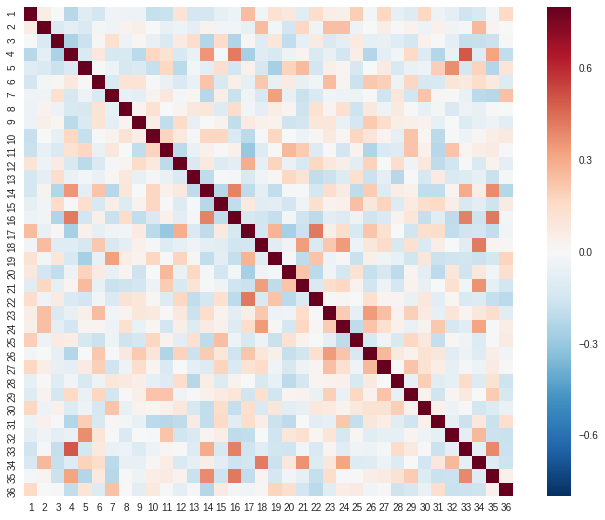

In [28]:
#correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## The we try to see meaning of dimensions by seeing which cancer types they encode.

In [29]:
labels = pd.concat([y_male, y_prost, y_luad, y_lusc, y_brca, y_acc, y_thca, y_gbm, y_lgg, y_kirc, y_kirp, y_kich], axis=1)
labels.columns = ['Male', 'PRAD', 'LUAD', 'LUSC', 'BRCA', 'ACC', 'THCA', 'GBM', 'LGG', 'KIRC', 'KIRP', 'KICH']
labels.head()

,Male,PRAD,LUAD,LUSC,BRCA,ACC,THCA,GBM,LGG,KIRC,KIRP,KICH
0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0


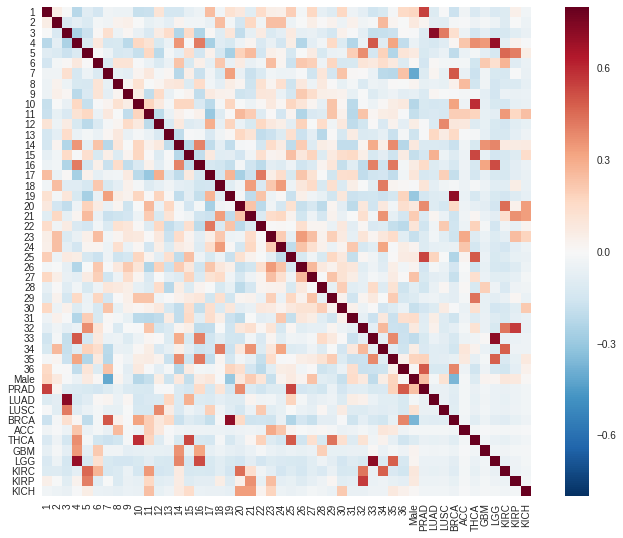

In [30]:
#correlation matrix
corrmat = pd.concat([X,labels],axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## Now let us put together all diseases grouped by correlation

In [58]:
tumor_types

['ACC',
 'BLCA',
 'BRCA',
 'CESC',
 'CHOL',
 'COAD',
 'DLBC',
 'ESCA',
 'GBM',
 'HNSC',
 'KICH',
 'KIRC',
 'KIRP',
 'LAML',
 'LGG',
 'LIHC',
 'LUAD',
 'LUSC',
 'MESO',
 'OV',
 'PAAD',
 'PCPG',
 'PRAD',
 'READ',
 'SARC',
 'SKCM',
 'STAD',
 'TGCT',
 'THCA',
 'THYM',
 'UCEC',
 'UCS',
 'UVM']

In [0]:
tumors_grouped = 'KIRC KIRP KICH ACC BRCA UCEC OV LIHC COAD READ STAD HNSC LUSC LUAD LGG LAML CESC CHOL BLCA GBM DLBC SARC MESO PCPG UCS UVM THYM THCA TGCT SKCM PRAD PAAD ESCA'.split()

In [72]:
len(tumors_grouped)

33

In [0]:
tumor_labels = []
for tumor in tumors_grouped:
  tumor_labels.append(pd.Series([1 if a==tumor else 0 for a in y1]))



In [74]:
labels = pd.concat(tumor_labels, axis=1)
labels.columns = tumors_grouped
labels.head()

,KIRC,KIRP,KICH,ACC,BRCA,UCEC,OV,LIHC,COAD,READ,...,PCPG,UCS,UVM,THYM,THCA,TGCT,SKCM,PRAD,PAAD,ESCA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#correlation matrix
corrmat = pd.concat([X,labels],axis=1).corr()
#corrs=corrmat.values
#tumor_features = corrs[36:,:33]

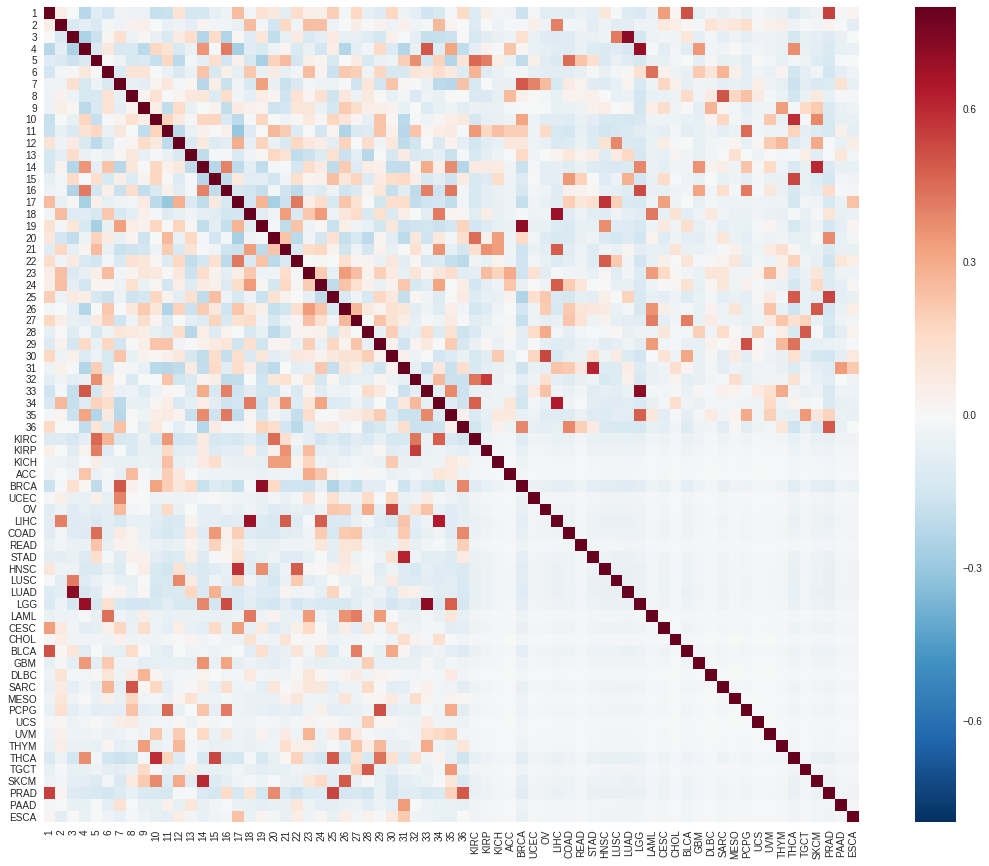

In [78]:
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True);

### Split data to training and test sections.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2)

In [87]:
X_train.shape

(9740, 36)

In [88]:
y_train.value_counts()

BRCA    1153
KIRC     601
LUAD     599
THCA     571
LUSC     545
HNSC     528
PRAD     525
LGG      453
LIHC     424
STAD     413
BLCA     383
SKCM     376
COAD     346
KIRP     313
CESC     256
OV       245
SARC     230
UCEC     181
ESCA     175
PCPG     162
GBM      157
PAAD     153
TGCT     135
KICH     121
READ     100
THYM      99
LAML      92
ACC       71
MESO      65
UVM       63
CHOL      51
UCS       46
DLBC      35
Name: acronym, dtype: int64

In [89]:
y_test.value_counts()

BRCA    345
KIRC    161
PRAD    143
THCA    135
LUAD    133
LUSC    112
LGG     111
HNSC    110
LIHC    105
SKCM    105
STAD    103
COAD     97
BLCA     89
KIRP     76
OV       73
CESC     61
SARC     47
ESCA     47
UCEC     44
PCPG     43
PAAD     40
TGCT     33
GBM      30
LAML     29
THYM     27
MESO     22
READ     22
KICH     20
UVM      17
DLBC     13
CHOL     12
UCS      11
ACC       8
Name: acronym, dtype: int64

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=10, verbose=1)

In [116]:
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         457.5880            7.02m
         2         132.7183            6.96m
         3         107.1885            5.70m
         4          87.4217            4.96m
         5          71.9328            4.46m
         6          59.7349            4.08m
         7          49.7981            3.79m
         8          41.7652            3.55m
         9          35.2805            3.34m
        10          29.9256            3.16m
        20           8.8263            1.97m
        30           5.5248            1.18m
        40           5.0417           33.11s
        50           4.9182            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [117]:
gb_model.score(X_train, y_train)

0.9925051334702258

In [118]:
gb_model.score(X_test, y_test)

0.9043121149897331

In [121]:
sorted(list(zip(gb_model.feature_importances_,X.columns)),reverse=True)

[(0.01673500674733801, '17'),
 (0.010670698407833433, '9'),
 (0.009396732206128671, '6'),
 (0.009186701013746433, '28'),
 (0.008987719667925137, '19'),
 (0.008160148582089856, '18'),
 (0.007712014849497005, '11'),
 (0.00742605738899962, '4'),
 (0.006597403640695625, '16'),
 (0.005455866299446665, '30'),
 (0.005239092298363445, '35'),
 (0.005200285399815928, '8'),
 (0.005092786057018259, '3'),
 (0.0050372002783238235, '5'),
 (0.004691565960216015, '27'),
 (0.004682128479194667, '22'),
 (0.0046389577940628415, '2'),
 (0.004070078423469646, '31'),
 (0.003796247575690326, '33'),
 (0.0035520569210398937, '26'),
 (0.0033565797765853517, '23'),
 (0.003342831991291422, '7'),
 (0.0033004049709940263, '15'),
 (0.003098600983583705, '13'),
 (0.003083933132821782, '25'),
 (0.0030100182972595995, '21'),
 (0.0029263549593064497, '1'),
 (0.002922021722178107, '10'),
 (0.002727045454162913, '24'),
 (0.0023553734911306175, '34'),
 (0.0022712875328307963, '29'),
 (0.002109368257399278, '20'),
 (0.001716

## Start with a simple decision tree classifier.

In [0]:
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
dt_model.score(X_train, y_train)

0.99435318275154

In [0]:
dt_model.score(X_test, y_test)

0.993429158110883

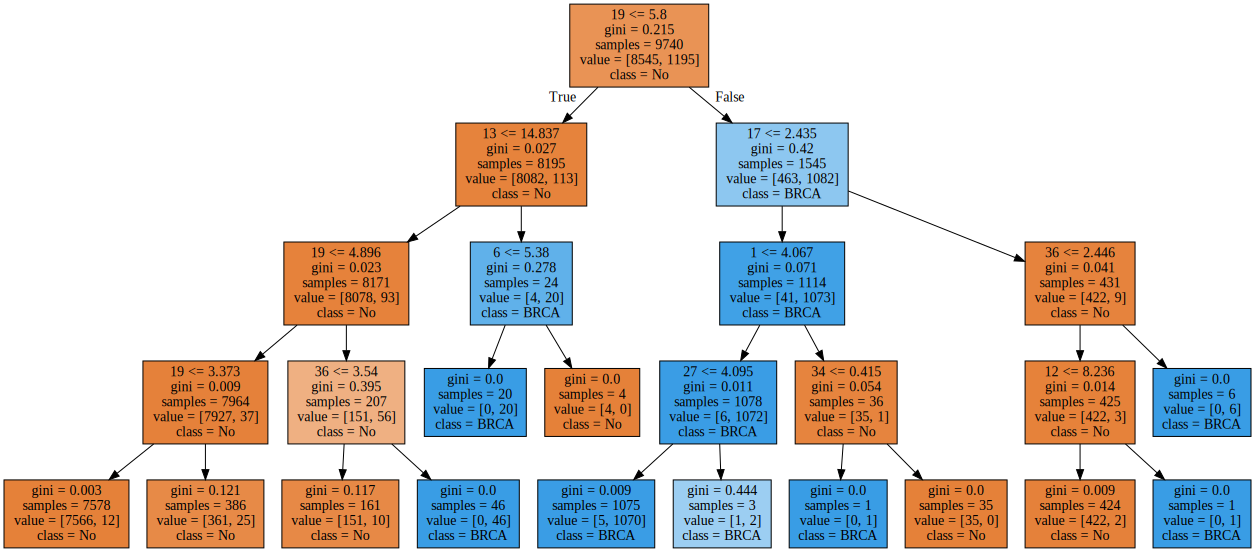

In [0]:
graph = Source(tree.export_graphviz(dt_model, out_file=None
   , feature_names=X.columns, class_names='No,BRCA'.split(',')
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [0]:
def print_decision_tree(tree, feature_names=None, offset_unit='    '):
    '''Plots textual representation of rules of a decision tree
    tree: scikit-learn representation of tree
    feature_names: list of feature names. They are set to f1,f2,f3,... if not specified
    offset_unit: a string of offset of the conditional block'''

    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    if feature_names is None:
        features  = ['f%d'%i for i in tree.tree_.feature]
    else:
        features  = [feature_names[i] for i in tree.tree_.feature]        

    def recurse(left, right, threshold, features, node, depth=0):
            offset = offset_unit*depth
            if (threshold[node] != -2):
                    print(offset+"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node],depth+1)
                    print(offset+"} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node],depth+1)
                    print(offset+"}")
            else:
                    print(offset+"return " + str(value[node]))

    recurse(left, right, threshold, features, 0,0)
print_decision_tree(dt_model, feature_names=X.columns, )

if ( 19 <= 5.799833297729492 ) {
    if ( 13 <= 14.836713790893555 ) {
        if ( 19 <= 4.895633220672607 ) {
            if ( 19 <= 3.3732542991638184 ) {
                return [[7566.   12.]]
            } else {
                return [[361.  25.]]
            }
        } else {
            if ( 36 <= 3.539609909057617 ) {
                return [[151.  10.]]
            } else {
                return [[ 0. 46.]]
            }
        }
    } else {
        if ( 6 <= 5.3801589012146 ) {
            return [[ 0. 20.]]
        } else {
            return [[4. 0.]]
        }
    }
} else {
    if ( 17 <= 2.4345645904541016 ) {
        if ( 1 <= 4.0673112869262695 ) {
            if ( 27 <= 4.094531059265137 ) {
                return [[   5. 1070.]]
            } else {
                return [[1. 2.]]
            }
        } else {
            if ( 34 <= 0.41529354453086853 ) {
                return [[0. 1.]]
            } else {
                return [[35.  0.]]
            }
 

(9740, 36)
n_digits: 33, 	 n_samples 9740, 	 n_features 36
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.86s	640250	0.944	0.105	0.188	0.021	0.104	0.363
random   	2.05s	720551	0.892	0.100	0.180	0.021	0.099	0.302
PCA-based	0.20s	788495	0.945	0.108	0.193	0.025	0.107	0.332
__________________________________________________________________________________


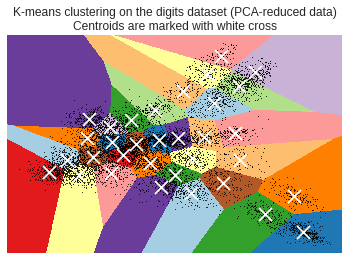

In [0]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)


data = X_train

n_samples, n_features = data.shape
print(n_samples, n_features)
n_digits = 33
labels = y_train

sample_size = 1000

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Random forest classifier for disease 

Let us use a random forest classifier to learn to detect disease from the activations of latent features.

An RF is an ensemble of trees, each tree is a classifier. RF builds n_estimators number of trees and averages their opinion. Since each tree only learns from a subset of rows and a subset of feature columns, it avoids overfitting.

In [0]:
rf_model = RandomForestClassifier(n_estimators=10, verbose=1)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

Let us see how well it has learned the training data

In [0]:
rf_model.score(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


1.0

But the real scoring is on the test data which teh model has not seen or memorized!

In [0]:
rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.9987679671457905

Since test is very bad compared to training, there is overfitting happening.  One way to reduce is to make sure there is enough samples at each tree. Let us tell the tree that it should not try to split a bucket if there are less than 4 examples in that bucket or if there will be less than 2 examples in the split result bucket.

In [0]:
N=1000

rf_model = RandomForestClassifier(n_estimators=N, min_samples_leaf=2, min_samples_split=4)
rf_model.fit(X_train, y_train)

train_score=rf_model.score(X_train, y_train)
test_score=rf_model.score(X_test, y_test)
print('Number of estimators =', N)
print('Train score:', train_score)
print('Test score:', test_score)

('Number of estimators =', 1000)
('Train score:', 0.9893223819301848)
('Test score:', 0.9363449691991786)


This is decent, but where is it going wrong? 

Let us explore the predictions and see which cancer types are getting missed out.

In [0]:
y_pred = rf_model.predict(X_test)

In [0]:
y_pred

array(['SKCM', 'BRCA', 'BRCA', ..., 'KIRP', 'OV', 'COAD'], dtype=object)

In [0]:
y_test.values

array(['SKCM', 'BRCA', 'BRCA', ..., 'KIRP', 'OV', 'COAD'], dtype=object)

In [0]:
confusion_matrix = pd.crosstab(y_pred, y_test)

In [0]:
confusion_matrix

acronym,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
row_0,,,,,,,,,,,,,,,,,,,,,
ACC,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BLCA,0,87,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
BRCA,0,0,315,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CESC,0,1,0,67,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,0
CHOL,0,0,0,0,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COAD,0,1,0,0,0,75,0,0,0,0,...,14,0,0,2,0,0,0,0,0,0
DLBC,0,0,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESCA,0,0,0,0,0,0,0,18,0,0,...,0,0,0,2,0,0,0,0,0,0
GBM,0,0,0,0,0,0,0,0,33,0,...,0,0,0,0,0,0,0,0,0,0


Let us make it more readable by plotting this information in a seaborn heatmap.

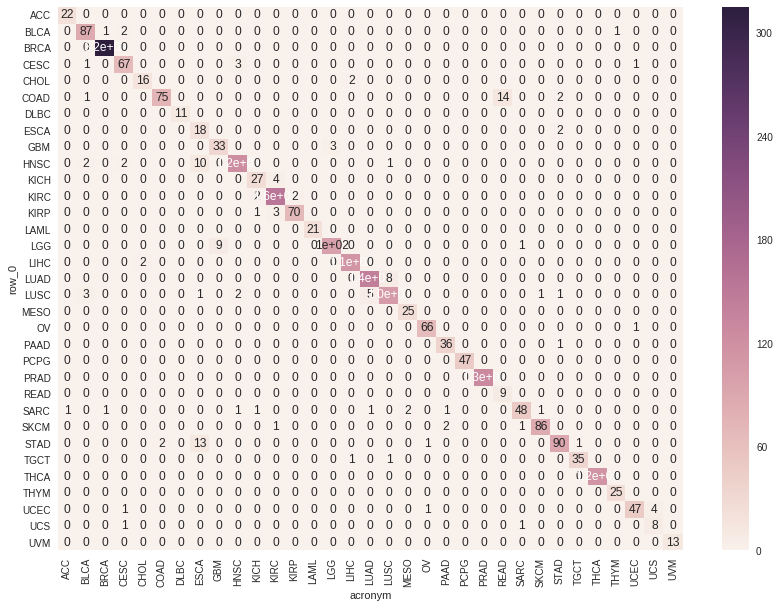

In [0]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,10)})
ax = sns.heatmap(confusion_matrix, annot=True)

In [0]:
from collections import Counter

confusions=Counter()
for i in range(X_test.shape[0]):
  pred=rf.predict([X_test.values[i]])[0]
  actual=y_test.values[i]
  if pred!=actual:
    print(i,pred,actual,pred==actual)
    confusions[pred,actual]+=1

(4, 'STAD', 'ESCA', False)
(35, 'COAD', 'PAAD', False)
(37, 'UCEC', 'LUAD', False)
(91, 'LIHC', 'CHOL', False)
(104, 'COAD', 'READ', False)
(109, 'HNSC', nan, False)
(117, 'GBM', 'LGG', False)
(124, 'LUAD', 'LUSC', False)
(125, 'HNSC', 'LUSC', False)
(147, 'HNSC', 'LUSC', False)
(154, 'HNSC', 'ESCA', False)
(168, 'SARC', 'MESO', False)
(227, 'HNSC', 'LUSC', False)
(252, 'PAAD', 'STAD', False)
(254, 'COAD', 'READ', False)
(262, 'STAD', 'ESCA', False)
(273, 'COAD', 'READ', False)
(291, 'STAD', 'CHOL', False)
(294, 'LUSC', 'ESCA', False)
(300, 'KIRC', 'KIRP', False)
(306, 'LIHC', 'CHOL', False)
(320, 'COAD', 'READ', False)
(329, 'LGG', 'GBM', False)
(357, 'STAD', 'OV', False)
(368, 'KIRC', 'KIRP', False)
(381, 'GBM', 'LGG', False)
(389, 'LUSC', 'LUAD', False)
(404, 'COAD', 'READ', False)
(412, 'LUSC', 'LUAD', False)
(424, 'LUAD', 'LUSC', False)
(429, 'UCEC', 'OV', False)
(438, 'STAD', 'ESCA', False)
(469, 'LIHC', 'CHOL', False)
(527, 'HNSC', 'ESCA', False)
(531, 'SARC', 'ACC', False)
(542

In [0]:
for d,c in confusions.most_common():
  print(d,c)

(('COAD', 'READ'), 17)
(('STAD', 'ESCA'), 14)
(('LUAD', 'LUSC'), 9)
(('LGG', 'GBM'), 8)
(('LAML', nan), 7)
(('LUSC', 'LUAD'), 6)
(('KIRC', 'KIRP'), 5)
(('HNSC', 'ESCA'), 5)
(('HNSC', 'LUSC'), 5)
(('LIHC', 'CHOL'), 4)
(('GBM', 'LGG'), 4)
(('LUSC', 'HNSC'), 3)
(('HNSC', nan), 3)
(('KIRP', 'KIRC'), 3)
(('BRCA', nan), 3)
(('KIRC', 'KICH'), 2)
(('CESC', 'HNSC'), 2)
(('HNSC', 'BLCA'), 2)
(('LUSC', 'ESCA'), 2)
(('STAD', 'COAD'), 2)
(('UCEC', 'OV'), 2)
(('SARC', 'MESO'), 2)
(('KIRP', 'KICH'), 2)
(('SARC', 'ACC'), 1)
(('STAD', 'CHOL'), 1)
(('STAD', 'OV'), 1)
(('SARC', 'PAAD'), 1)
(('LUSC', 'BLCA'), 1)
(('BLCA', 'THYM'), 1)
(('STAD', 'READ'), 1)
(('BLCA', 'HNSC'), 1)
(('STAD', 'PAAD'), 1)
(('UCEC', 'LUAD'), 1)
(('PAAD', 'SKCM'), 1)
(('UCS', 'BLCA'), 1)
(('UCEC', 'UCS'), 1)
(('COAD', 'CESC'), 1)
(('BRCA', 'ESCA'), 1)
(('SARC', 'BRCA'), 1)
(('COAD', 'PAAD'), 1)
(('UCEC', 'LGG'), 1)
(('COAD', nan), 1)
(('PAAD', 'STAD'), 1)
(('OV', 'UCEC'), 1)
(('UCS', 'SARC'), 1)
(('PCPG', 'UVM'), 1)
(('READ', 'COA

What dimensions are most useful for disease classification? A RF model allows you to query feature importances.

In [0]:
rf_model.feature_importances_

array([0.24658819, 0.00301176, 0.0004001 , 0.00305343, 0.00106434,
       0.01928466, 0.00155214, 0.00147462, 0.00031504, 0.00388189,
       0.00356735, 0.01574494, 0.00171285, 0.00266797, 0.00109506,
       0.08137914, 0.00141569, 0.06820328, 0.01124038, 0.17862448,
       0.00253549, 0.00749945, 0.00228131, 0.0042252 , 0.17785708,
       0.00868533, 0.001306  , 0.00614629, 0.00035092, 0.00991922,
       0.00383444, 0.00107849, 0.00087558, 0.00027011, 0.01194545,
       0.11491233])

In [0]:
X.columns

Index([u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'10', u'11',
       u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21',
       u'22', u'23', u'24', u'25', u'26', u'27', u'28', u'29', u'30', u'31',
       u'32', u'33', u'34', u'35', u'36'],
      dtype='object')

In [0]:
list(zip(X.columns, rf_model.feature_importances_))

[('1', 0.24658819230338058),
 ('2', 0.0030117644680011904),
 ('3', 0.00040010237209364523),
 ('4', 0.003053429108138652),
 ('5', 0.0010643426481953073),
 ('6', 0.01928466272343978),
 ('7', 0.0015521423843323178),
 ('8', 0.001474619973578324),
 ('9', 0.00031504069741203117),
 ('10', 0.00388188515126731),
 ('11', 0.003567351718768691),
 ('12', 0.015744943455362658),
 ('13', 0.0017128541110099115),
 ('14', 0.0026679687637111865),
 ('15', 0.00109505710339104),
 ('16', 0.081379140806746),
 ('17', 0.001415687975398611),
 ('18', 0.06820327992804348),
 ('19', 0.011240379766439818),
 ('20', 0.17862448276510684),
 ('21', 0.002535493133391468),
 ('22', 0.007499446299603649),
 ('23', 0.0022813126742791566),
 ('24', 0.004225197496836193),
 ('25', 0.1778570785646818),
 ('26', 0.00868532569098623),
 ('27', 0.0013060015633519278),
 ('28', 0.0061462874400279605),
 ('29', 0.0003509151914983986),
 ('30', 0.00991922496152944),
 ('31', 0.003834442738305734),
 ('32', 0.0010784882157826897),
 ('33', 0.000875

In [0]:
sorted(list(zip(X.columns,list(rf_model.feature_importances_))), key=lambda k:k[1], reverse=True)

[('1', 0.24658819230338058),
 ('20', 0.17862448276510684),
 ('25', 0.1778570785646818),
 ('36', 0.11491232548673609),
 ('16', 0.081379140806746),
 ('18', 0.06820327992804348),
 ('6', 0.01928466272343978),
 ('12', 0.015744943455362658),
 ('35', 0.01194544935296021),
 ('19', 0.011240379766439818),
 ('30', 0.00991922496152944),
 ('26', 0.00868532569098623),
 ('22', 0.007499446299603649),
 ('28', 0.0061462874400279605),
 ('24', 0.004225197496836193),
 ('10', 0.00388188515126731),
 ('31', 0.003834442738305734),
 ('11', 0.003567351718768691),
 ('4', 0.003053429108138652),
 ('2', 0.0030117644680011904),
 ('14', 0.0026679687637111865),
 ('21', 0.002535493133391468),
 ('23', 0.0022813126742791566),
 ('13', 0.0017128541110099115),
 ('7', 0.0015521423843323178),
 ('8', 0.001474619973578324),
 ('17', 0.001415687975398611),
 ('27', 0.0013060015633519278),
 ('15', 0.00109505710339104),
 ('32', 0.0010784882157826897),
 ('5', 0.0010643426481953073),
 ('33', 0.0008755760503044076),
 ('3', 0.00040010237

# Keras classifier

In [0]:
# based on https://github.com/keras-team/keras/blob/master/examples/reuters_mlp.py

In [0]:
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le=LabelEncoder()
y_train=y_train.fillna('NA')
y_test=y_test.fillna('NA')
le.fit(y_train)
print(le.classes_)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)
#le.inverse_transform(y_train_label)

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'NA' 'OV'
 'PAAD' 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM'
 'UCEC' 'UCS' 'UVM']


In [0]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

num_classes = np.max(y_train_label) + 1
print(num_classes, 'classes')

y_train_cat = keras.utils.to_categorical(y_train_label, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_label, num_classes)

print('y_train shape:', y_train_cat.shape)
print('y_test shape:', y_test_cat.shape)

9740 train sequences
2435 test sequences
34 classes
y_train shape: (9740, 34)
y_test shape: (2435, 34)


In [0]:
X_train.shape

(9740, 36)

In [0]:
print('Building model...')
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(Activation('sigmoid'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model...


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               9472      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 34)                4386      
_________________________________________________________________
activation_3 (Activation)    (None, 34)                0         
Total para

In [0]:
batch_size = 128
epochs = 50

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_cat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


Train on 8766 samples, validate on 974 samples
Epoch 1/50
8766/8766 [==============================] - 3s 295us/step - loss: 2.0018 - acc: 0.5240 - val_loss: 0.8166 - val_acc: 0.8203
Epoch 2/50
8766/8766 [==============================] - 0s 45us/step - loss: 0.7676 - acc: 0.8139 - val_loss: 0.4392 - val_acc: 0.8809
Epoch 3/50
8766/8766 [==============================] - 0s 46us/step - loss: 0.5387 - acc: 0.8564 - val_loss: 0.3481 - val_acc: 0.8963
Epoch 4/50
8766/8766 [==============================] - 0s 46us/step - loss: 0.4449 - acc: 0.8719 - val_loss: 0.3026 - val_acc: 0.9055
Epoch 5/50
8766/8766 [==============================] - 0s 45us/step - loss: 0.4051 - acc: 0.8796 - val_loss: 0.2847 - val_acc: 0.9066
Epoch 6/50
8766/8766 [==============================] - 0s 46us/step - loss: 0.3643 - acc: 0.8887 - val_loss: 0.2695 - val_acc: 0.9148
Epoch 7/50
8766/8766 [==============================] - 0s 49us/step - loss: 0.3473 - acc: 0.8885 - val_loss: 0.2633 - val_acc: 0.9189
Epoch 8

In [0]:
score = model.evaluate(X_test, y_test_cat,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2435/2435 [==============================] - 0s 15us/step
Test score: 0.20826110767020828
Test accuracy: 0.9326488706365503


In [0]:
model.save('cancer_type_from_latent36.h5')

In [0]:
files.download('cancer_type_from_latent36.h5')

## Trying a single layer model to see if linear separation is sufficient and also to see disease signature on features.

In [0]:
print('Building model...')
model = Sequential()
model.add(Dense(num_classes, input_shape=(X_train.shape[1],)))
model.add(Activation('softmax'))
model.summary()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 34)                1258      
_________________________________________________________________
activation_5 (Activation)    (None, 34)                0         
Total params: 1,258
Trainable params: 1,258
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 128
epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_cat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8766 samples, validate on 974 samples
Epoch 1/50
8766/8766 [==============================] - 0s 52us/step - loss: 5.1024 - acc: 0.1715 - val_loss: 3.4644 - val_acc: 0.2772
Epoch 2/50
8766/8766 [==============================] - 0s 32us/step - loss: 2.5449 - acc: 0.4046 - val_loss: 1.7704 - val_acc: 0.5092
Epoch 3/50
8766/8766 [==============================] - 0s 31us/step - loss: 1.3685 - acc: 0.6143 - val_loss: 0.9987 - val_acc: 0.7259
Epoch 4/50
8766/8766 [==============================] - 0s 34us/step - loss: 0.8578 - acc: 0.7687 - val_loss: 0.7006 - val_acc: 0.8101
Epoch 5/50
8766/8766 [==============================] - 0s 33us/step - loss: 0.6470 - acc: 0.8176 - val_loss: 0.5611 - val_acc: 0.8429
Epoch 6/50
8766/8766 [==============================] - 0s 34us/step - loss: 0.5380 - acc: 0.8438 - val_loss: 0.4789 - val_acc: 0.8655
Epoch 7/50
8766/8766 [==============================] - 0s 36us/step - loss: 0.4703 - acc: 0.8583 - val_loss: 0.4305 - val_acc: 0.8737
Epoch 8/

In [0]:
score = model.evaluate(X_test, y_test_cat,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2435/2435 [==============================] - 0s 17us/step
Test score: 0.2378802023720937
Test accuracy: 0.922381930184805


## Saving and loading models.

In [0]:
model.save('cancer_type_from_latent36_linear.h5')

In [0]:
files.download('cancer_type_from_latent36_linear.h5')

In [0]:
from keras.models import load_model

In [0]:
model = load_model('cancer_type_from_latent36_linear.h5')

In [0]:
score = model.evaluate(X_test, y_test_cat,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2435/2435 [==============================] - 0s 34us/step
Test score: 0.2378802023720937
Test accuracy: 0.922381930184805


## Extract layer weights and save to file

In [0]:
# Extract the weights from the decoder model
weights = []
for layer in model.layers:
    print(layer)
    weights.append(layer.get_weights())
    
weight_layer_df = pd.DataFrame(weights[0][0], columns=le.classes_, index=range(1, 37))
weight_layer_df.index.name = 'encodings'
print(weight_layer_df.shape)
weight_layer_df.head(2)

(36, 34)


,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
encodings,,,,,,,,,,,,,,,,,,,,,
1,0.038812,0.404669,-0.267646,0.274243,0.115107,-0.396533,-0.535608,-0.206778,-0.557463,-0.297309,...,-0.314899,-0.257784,-0.204999,-0.245990,-0.061690,-0.615195,-0.369269,-0.082439,-0.105570,-0.232398
2,0.088165,0.125356,0.121114,0.129798,0.219448,-0.000364,0.082286,-0.508855,0.036877,0.193633,...,-0.077409,0.228597,-0.053956,-0.344146,0.086423,-0.031250,0.267000,0.063108,0.138542,-0.017810


In [0]:
# Write the genes to file
weight_file = 'keras_onelayer_latent_weights.tsv'
weight_layer_df.to_csv(weight_file, sep='\t')

In [0]:
files.download(weight_file)

In [0]:
weight_layer_df.loc[:,'PRAD']

encodings
1     0.145678
2     0.183020
3    -0.178668
4    -0.116321
5    -0.254103
6    -0.653933
7    -0.075905
8    -0.087970
9    -0.070535
10   -0.453840
11   -0.106617
12   -0.044959
13    0.147612
14   -0.460538
15   -0.135350
16    0.152053
17   -0.795147
18    0.252683
19   -0.538803
20    0.175911
21   -0.000397
22   -0.378855
23   -0.022567
24   -0.122624
25    0.118417
26   -0.070791
27    0.084596
28   -0.241811
29    0.109527
30   -0.038213
31   -0.224326
32   -0.021518
33   -0.419359
34   -0.397275
35    0.149777
36    0.234845
Name: PRAD, dtype: float32

In [0]:
weight_layer_df.loc[:,'PRAD'].abs().sort_values(ascending=False).index

Int64Index([17,  6, 19, 14, 10, 33, 34, 22,  5, 18, 28, 36, 31,  2,  3, 20, 16,
            35, 13,  1, 15, 24, 25,  4, 29, 11,  8, 27,  7, 26,  9, 12, 30, 23,
            32, 21],
           dtype='int64', name=u'encodings')